# Subscription Cancellation Metric Plots

# Setup

To start, we first import the necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Directions

The below cells will each prompt you for the a file upload. The first file should be in the same format as the `nps_comments.csv` file shared with our team. The second should be in the same format as `product_reviews.csv`, and the thirs should be in the same format as `subscription_cancellations.csv`.

There is also a table of contents on the left sidebar to help with navigation!

In [ ]:
uploaded_nps = files.upload()

In [ ]:
uploaded_pr = files.upload()

In [ ]:
uploaded_sc = files.upload()

In [ ]:
import io
comments = pd.read_csv(io.BytesIO(uploaded_nps['nps_comments.csv']))
reviews = pd.read_csv(io.BytesIO(uploaded_pr['product_reviews.csv']))
cancellations = pd.read_csv(io.BytesIO(uploaded_sc['subscription_cancellations.csv']))

# Data Cleaning

Cleaning the datasets a bit. I mainly dropped empty data and combined categories for analysis. Some of this cleaning is specific to the given datasets.

In [ ]:
# There were empty rows in the dataset so take them out
reviews = reviews.iloc[:1298]

In [ ]:
# Some cancellation reasons were repetitive so I combined some categories together for better analysis
cancellations["cancellation_reason"] = cancellations["cancellation_reason"].replace({"Other reason": "Other", "The product didn't work for me": "The product/formula didn't work for me", "The formula didn't work for me":"The product/formula didn't work for me"})

In [ ]:
# Got rid of a default message comment because didn't gave as much insight as other comments
# If there are a high proportion of this comment, then it could eventually be problematic
cancellations = cancellations[cancellations["cancellation_reason_comments"] != "Item cancelled for reason: 'stop_retrying' by CUSTOMER"]

## Word Tokenization

Here, I clean up the comments and tokenize them by lowercasing the words, removing stopwords and numbers, and using a porter stemmer for words that are similar. Each list is a set of the words meaning each word will only appear once in the list per comment.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Getting english stopwords to remove in the text since these words provide no meaning
stopwordList = set(stopwords.words("english"))

In [ ]:
# Stemmer that will help group words based on their common base form
porter = PorterStemmer()

# Grabbing the column in the dataset that has text to be analyzed
comment_comments = comments["Comment"].astype(str)
commentCommentsTokenized = []
review_comments = reviews["REVIEW"].astype(str)
reviewCommentsTokenized = []
cancellation_comments = cancellations["cancellation_reason_comments"].astype(str)
cancellationCommentsTokenized = []

# Looping through each comment and tokenizing each comment which will make a list of word tokens per comment
for line in comment_comments:
    lowerCased = line.lower()
    noPunct = lowerCased.translate(str.maketrans('', '', string.punctuation))
    tokenized = set(noPunct.split())
    tokens_without_sw = [porter.stem(word) for word in tokenized if not word in stopwordList and not word.isnumeric()]
    commentCommentsTokenized.append(tokens_without_sw)
for line in review_comments:
    lowerCased = line.lower()
    noPunct = lowerCased.translate(str.maketrans('', '', string.punctuation))
    tokenized = set(noPunct.split())
    tokens_without_sw = [porter.stem(word) for word in tokenized if not word in stopwordList and not word.isnumeric()]
    reviewCommentsTokenized.append(tokens_without_sw)
for line in cancellation_comments:
    lowerCased = line.lower()
    noPunct = lowerCased.translate(str.maketrans('', '', string.punctuation))
    tokenized = set(noPunct.split())
    tokens_without_sw = [porter.stem(word) for word in tokenized if not word in stopwordList and not word.isnumeric()]
    cancellationCommentsTokenized.append(tokens_without_sw)
    
# Adding the list of tokens as a column to the dataset
comments["words"] = commentCommentsTokenized
reviews["words"] = reviewCommentsTokenized
cancellations["words"] = cancellationCommentsTokenized

The next function is simply compiling the list of lists into a single list of words. It is used as a helper function for the future functions.

In [ ]:
# Plug in a Series with the list of words per row or a list of list of words into this function to 
# combine all words together. Returns a single list that combines the words in the list of lists.
def collectionOfWords(listOfListOfWords):
    words = np.array([])
    for text in listOfListOfWords:
        for word in text:
            words = np.append(word, words)
    return words

# Wordcloud making function
def plot_cloud(wordcloud):
    plt.figure(figsize = (40,30))
    plt.imshow(wordcloud)
    plt.axis("off");
    

# Cancellations Over Time

Here we try to analyze if we can find any insight on cancellations over time or by month. When looking at over time, each point is the total amount of cancellations for that month and year. One major problem is that the amount of consumers is not taken into account so while cancellations are increasing over time, it could also be due to more customers. If we had data regarding the customer base, we could probably use something like a proportion for better analysis.

In [ ]:
# Based off the format given, we can extract the month and year of the cancellation. A better way, if the format is wacky
# at times, is using regex but for the dataset given, it seems using string manipulation is fine.
month = cancellations["cancelled_at"].str[5:7].astype(int)
year = cancellations["cancelled_at"].str[:4].astype(int)

# Place the month and year of the cancellation as their own column in the dataset
cancellations["month"] = month
cancellations["year"] = year

# There is a default date of January 1st, 1970. There is only a small amount and this will affect the analysis thus remove
# these default values.
withoutDefaultTime = cancellations[cancellations["cancelled_at"].str[:4] != "1970"]
monthSizeTable = withoutDefaultTime.loc[:, ["month", "year"]].sort_values(by = ["month", "year"]).groupby(by = ["month"]).size().reset_index().rename(columns = {0: "count"})

This next line of code simply creates a lineplot with month on the x, and the count of subscription cancellations on the y. It uses the data table created from the previous lines of code.

Text(0.5, 1.0, 'Subscription Cancellation by Month')

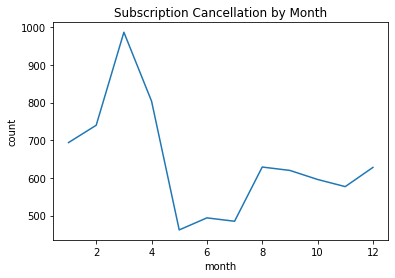

In [ ]:
sns.lineplot(data = monthSizeTable, x = "month", y="count")
plt.title("Subscription Cancellation by Month")

This next line of code groups the data table by month and year so that we can get the subscription cancellations per month and year combination. This way, we can see the progression of subscription cancellations.

In [ ]:
monthYearCount = withoutDefaultTime.loc[:, ["month", "year"]].groupby(by = ["month", "year"]).size().reset_index().rename(columns={0:"count"}).sort_values(by = ["year", "month"])
monthYearCount["x"] = np.arange(len(monthYearCount))


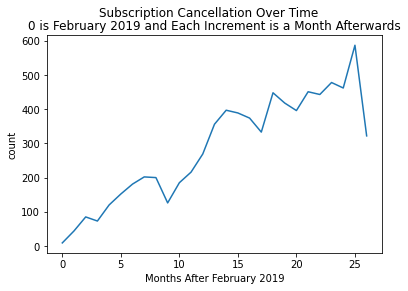

In [ ]:
sns.lineplot(data = monthYearCount, x = "x", y = "count")
plt.suptitle("Subscription Cancellation Over Time")
plt.title("0 is February 2019 and Each Increment is a Month Afterwards")
plt.xlabel("Months After February 2019")
plt.show()

# Score/Rating Distribution by Word

The next functions are used for the nps_comments and product_reviews dataset. The first function simply lists the most frequent words in the comments. You specify a threshold as a decimal where words that are higher than the threshold percentage of the comments will be listed out. The next few functions create a score/rating distribution based off a given word. The extra function that deals with weights is a little faulty as it attempts to weight each score/rating differently since the dataset contains uneven amounts of a certain score (for example, more 10s than 5s). The current implementation uses and inverse proportions as weights. 

In [ ]:
# function that takes in df, the col name of the col that has the list of words, and a threshold as a decimal (0 <= x <= 1) and 
# returns a series of words that are higher than threshold
def frequentWords(df, colWithListOfWords, threshold):
    allWords = collectionOfWords(df[colWithListOfWords])
    newDF = pd.DataFrame({"words": allWords}).apply(pd.value_counts).reset_index().rename(columns={"index":"word", "words":"count"})
    newDF["proportion"] = newDF["count"] / df.shape[0]
    filteredDF = newDF[newDF["proportion"] >= threshold]
    return filteredDF["word"]

# plots a histogram distribution of a score filtered on the dataframe if the comment contains a certain word
def scoreDistributionOfWord(df, colWithListOfWords, word):
    thingsWithWord = df[[word in text for text in df[colWithListOfWords]]]
    sns.histplot(data = thingsWithWord, x = "Score")
    
# similar to score distribution but uses weights on the scores due to class imbalance...
# still need to improve how to calculate weights as it is based off inverse proportions currently
def scoreDistributionOfWordWithWeights(df, colWithListOfWords, word):
    weights = df["Score"].shape[0] / (len(df["Score"].value_counts()) * df["Score"].value_counts())
    y = pd.DataFrame({"Weight":weights}).reset_index()
    thingsWithWord = df[[word in text for text in df[colWithListOfWords]]]
    x = thingsWithWord[["Score"]].apply(pd.value_counts).reset_index()
    x = x.merge(y, on="index")
    x["New Count"] = x["Score"] * x["Weight"]
    x = x.sort_values(by="index")
    sns.barplot(data=x, x="index", y="New Count") 

# creates a barplot of the count of reviews/comments that contain the word based off each rating type
def ratingDistributionOfWord(df, colWithListOfWords, word):
    thingsWithWord = df[[word in text for text in df[colWithListOfWords]]]
    thingsWithWord = thingsWithWord.sort_values(by="RATING")
    sns.countplot(data = thingsWithWord, x = "RATING")
    
# similar to rating distribution above but uses weights due to small class imbalance...
# still need to improve how to calculate weights as it is based off inverse proportions currently
def ratingDistributionOfWordWithWeights(df, colWithListOfWords, word):
    weights = df["RATING"].shape[0] / (len(df["RATING"].value_counts()) * df["RATING"].value_counts())
    y = pd.DataFrame({"Weight":weights}).reset_index()
    thingsWithWord = df[[word in text for text in df[colWithListOfWords]]]
    x = thingsWithWord[["RATING"]].apply(pd.value_counts).reset_index()
    x = x.merge(y, on="index")
    x["New Count"] = x["RATING"] * x["Weight"]
    x = x.sort_values(by="index")
    sns.barplot(data=x, x="index", y="New Count")

Example usages

In [ ]:
# This will list all the words that show up in more than 10% of comments data set
# The above steps created the token of words in a column called "words" for the table thus we use "words" in this function
frequentWords(comments, "words", .1)

0     product
1        love
2      deodor
3         use
4        work
5       great
6        like
7     plastic
8     shampoo
9      packag
10       good
11        tri
12      smell
Name: word, dtype: object

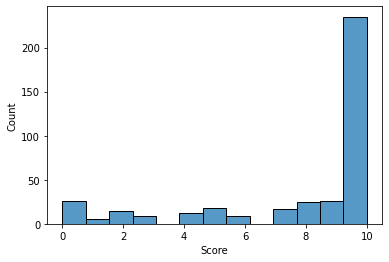

In [ ]:
scoreDistributionOfWord(comments, "words", "packag")

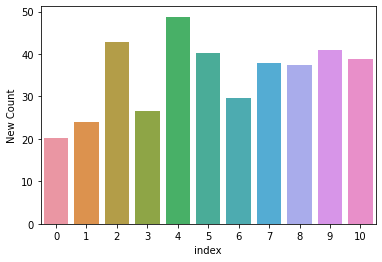

In [ ]:
scoreDistributionOfWordWithWeights(comments, "words", "packag")

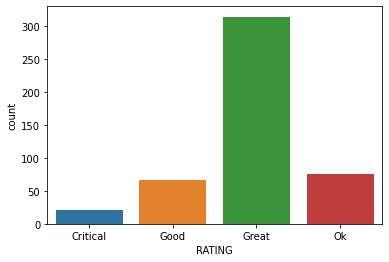

In [ ]:
ratingDistributionOfWord(reviews, "words", "love")

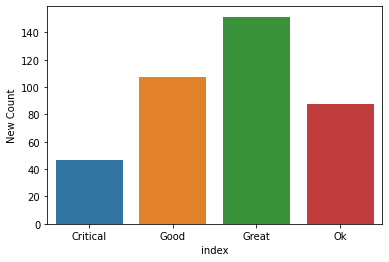

In [ ]:
ratingDistributionOfWordWithWeights(reviews, "words", "love")

In general, the frequentWords function works well with the distributions as you would like to see the distribution of words that commonly appear in the comments/reviews so you can simply look at the words generated from frequentWords and choose words from there.